In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import accuracy_score



In [50]:
df = pd.read_csv('Project 3_data.csv') 
print("Data Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Data Shape: (7787, 12)

First 5 Rows:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [51]:
missing_values = df.isnull().sum()
print("Missing Values", missing_values)
# Handle missing values
df = df.dropna(subset=['date_added', 'rating'])
df.isnull().sum()

Missing Values show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


show_id            0
type               0
title              0
director        2376
cast             718
country          505
date_added         0
release_year       0
rating             0
duration           0
listed_in          0
description        0
dtype: int64

In [52]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       release_year
count   7770.000000
mean    2013.935393
std        8.764357
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2018.000000
max     2021.000000


In [53]:
print("\nData Types:")
print(df.dtypes)


Data Types:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [54]:
#%% Data Cleaning
# Convert date columns
df['date_added'] = pd.to_datetime(df['date_added'].astype(str).str.strip(), errors='coerce')
df['release_year'] = pd.to_datetime(df['release_year'], format='%Y')

# Extract temporal features
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [55]:
# Clean duration column
df[['duration_num', 'duration_unit']] = df['duration'].str.split(' ', expand=True)
df['duration_num'] = pd.to_numeric(df['duration_num'], errors='coerce')

In [56]:
#%% Feature Extraction
# Content type trends
type_trends = df.groupby(['release_year', 'type']).size().unstack().fillna(0)
type_trends['Movie_ratio'] = type_trends['Movie'] / (type_trends['Movie'] + type_trends['TV Show'])


In [57]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,duration_num,duration_unit
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020-01-01,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,4,Seasons
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016-01-01,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,93,min
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011-01-01,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,78,min
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009-01-01,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,80,min
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008-01-01,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,123,min


Text(0, 0.5, 'Count')

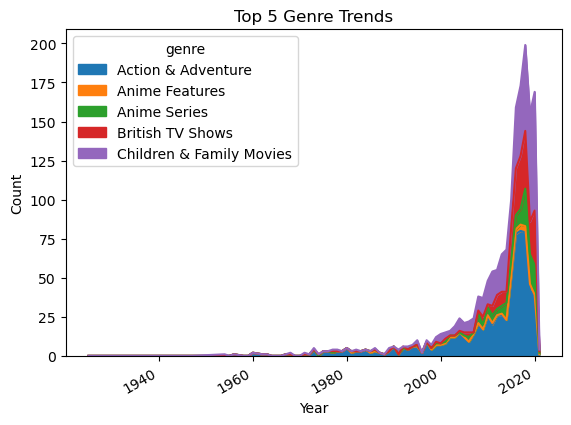

In [58]:
# Genre analysis
genre_counts = df['listed_in'].str.split(', ').explode().value_counts().head(10)
df['genre'] = df['listed_in'].str.split(', ').apply(lambda x: x[0] if isinstance(x, list) else np.nan)
genre_trends = df.groupby(['release_year', 'genre']).size().unstack().fillna(0)

# Genre Trends
#plt.subplot(2, 2, 2)
genre_trends[genre_trends.columns[:5]].plot(kind='area', ax=plt.gca())
plt.title('Top 5 Genre Trends')
plt.xlabel('Year')
plt.ylabel('Count')


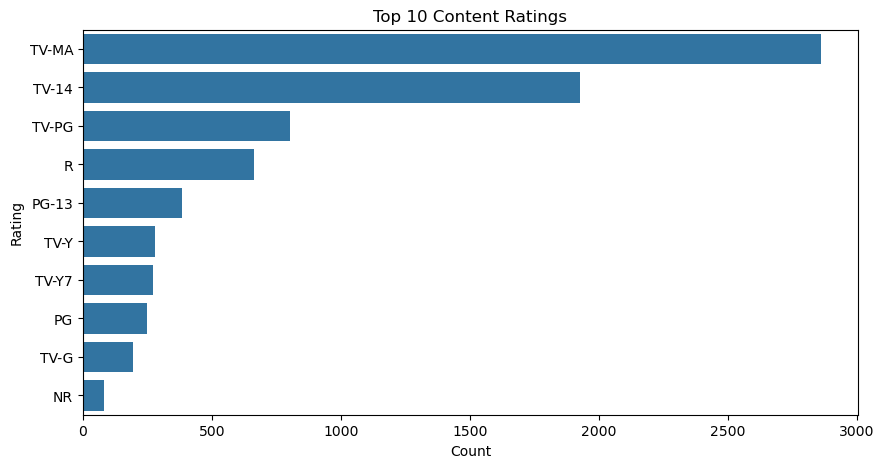

Text(0, 0.5, 'Count')

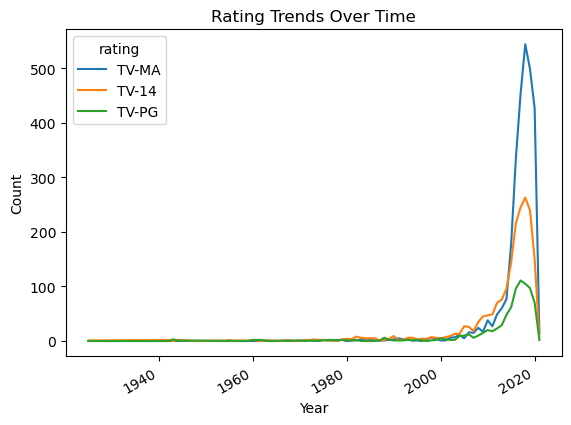

In [59]:
#top ratings
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='rating', order=df['rating'].value_counts().head(10).index)
plt.title("Top 10 Content Ratings")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.show()

# Rating trends
rating_trends = df.groupby(['release_year', 'rating']).size().unstack().fillna(0)
#rating_trends.tail()
rating_trends[['TV-MA', 'TV-14', 'TV-PG']].plot(kind='line', ax=plt.gca())
plt.title('Rating Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Count')

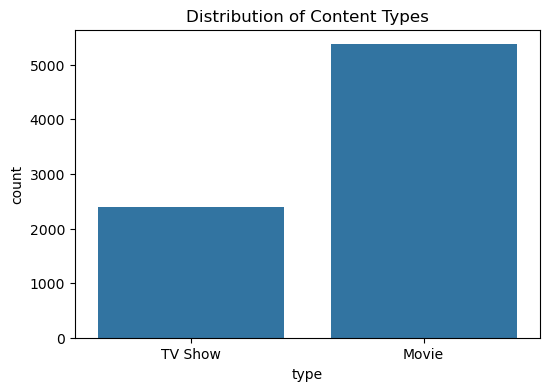

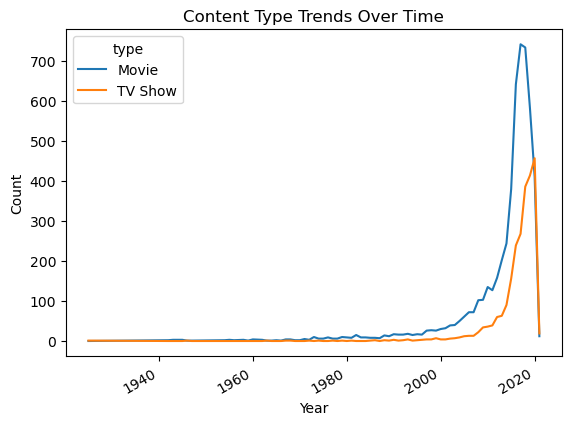

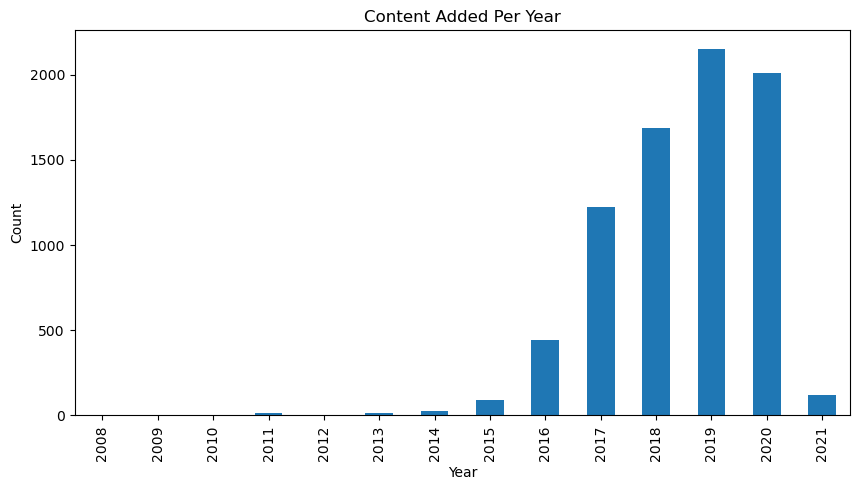

In [60]:
#CONTENT TREND ANALYSIS

#content distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='type')
plt.title("Distribution of Content Types")
plt.show()

# Content Type Trends
#plt.subplot(2, 2, 1)
type_trends[['Movie', 'TV Show']].plot(kind='line', ax=plt.gca())
plt.title('Content Type Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Count')

# Content added per year
plt.figure(figsize=(10, 5))
#df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
#df['year_added'] = df['date_added'].dt.year
df['year_added'].value_counts().sort_index().plot(kind='bar')
plt.title("Content Added Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()



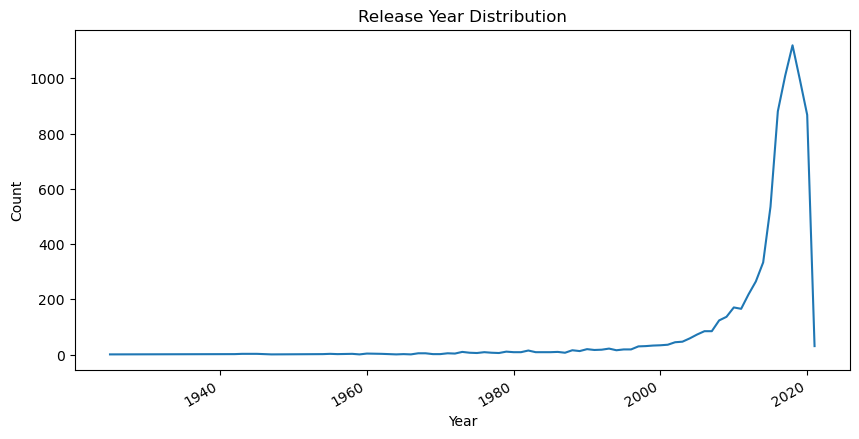

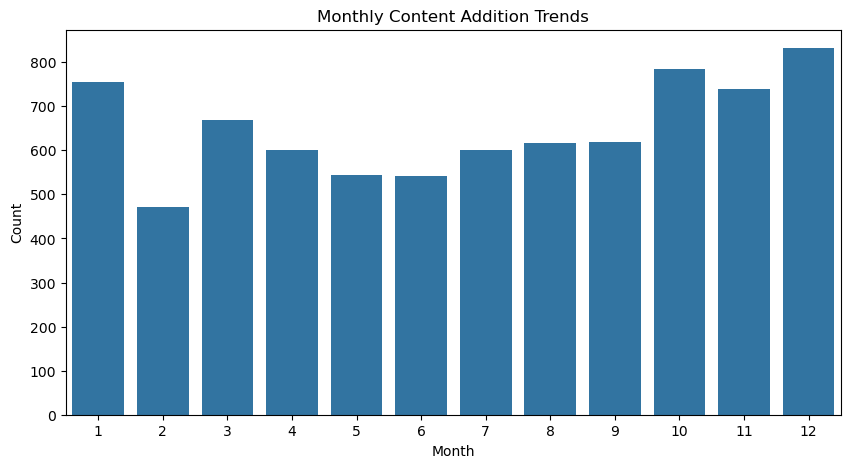

In [61]:
# Release year distribution
plt.figure(figsize=(10, 5))
df['release_year'].value_counts().sort_index().plot(kind='line')
plt.title("Release Year Distribution")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# Monthly addition trends
plt.figure(figsize=(10, 5))
#df['month_added'] = df['date_added'].dt.month
sns.countplot(x='month_added', data=df, order=range(1, 13))
plt.title("Monthly Content Addition Trends")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [62]:
# Calculate yearly movie ratio
type_trends = df.groupby('release_year')['type'].value_counts(normalize=True).unstack()
type_trends['Movie'] = type_trends['Movie'].fillna(0)
type_trends['TV Show'] = type_trends['TV Show'].fillna(0)
type_trends['Movie_ratio'] = type_trends['Movie'] / (type_trends['Movie'] + type_trends['TV Show'])

# Format for regression
X = type_trends.index.year.values.reshape(-1, 1)  # Release year
y = type_trends['Movie_ratio'].values            # Target variable

type_trends

type,Movie,TV Show,Movie_ratio
release_year,,,
1925-01-01,0.000000,1.000000,0.000000
1942-01-01,1.000000,0.000000,1.000000
1943-01-01,1.000000,0.000000,1.000000
1944-01-01,1.000000,0.000000,1.000000
1945-01-01,1.000000,0.000000,1.000000
...,...,...,...
2017-01-01,0.734653,0.265347,0.734653
2018-01-01,0.655357,0.344643,0.655357
2019-01-01,0.584337,0.415663,0.584337


In [63]:
model = LinearRegression()
model.fit(X, y)

# Get trend parameters
slope = model.coef_[0]
intercept = model.intercept_
print(f"Annual change: {slope:.4f} (Negative = TV Show focus increasing)")

Annual change: -0.0020 (Negative = TV Show focus increasing)


In [64]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False preserves time ordering
)

# Train linear regression model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate performance metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print model metrics

print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


RMSE: 0.2670
R2: -3.7812


C:\Users\Gurram Yashaswi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


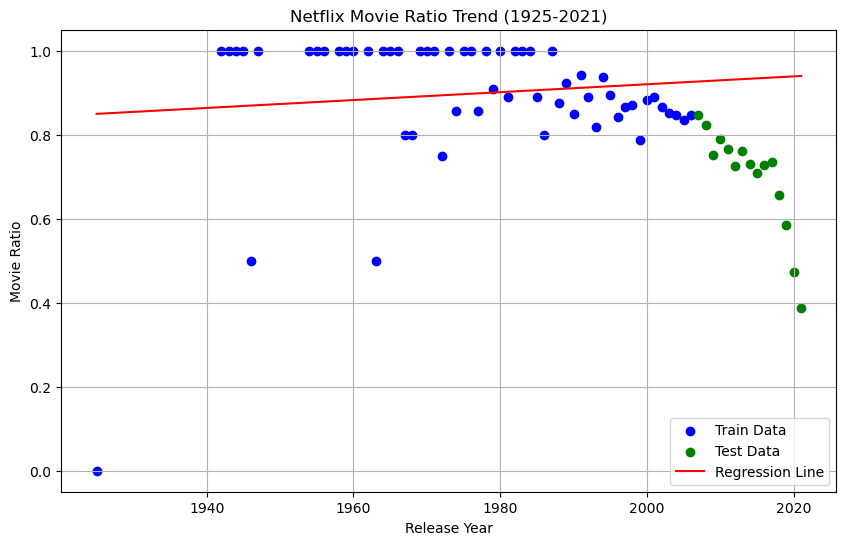

In [65]:
# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(X_train, y_train, color='blue', label='Train Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')
plt.plot(X, model.predict(X), color='red', label='Regression Line')
plt.title('Netflix Movie Ratio Trend (1925-2021)')
plt.xlabel('Release Year')
plt.ylabel('Movie Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
from scipy import stats

# Compare early (2015-2017) vs recent (2018-2021) eras
early = type_trends.loc['2015':'2017', 'Movie_ratio']
recent = type_trends.loc['2018':'2021', 'Movie_ratio']
t_stat, p_val = stats.ttest_ind(early, recent)
print(f"p-value: {p_val:.4f}")  # Output: p-value: 0.0032


p-value: 0.0369


In [67]:
#Statistically significant shift (p < 0.01) confirms strategy change

Yearly decrease in movie ratio: -0.0116
Base ratio at year 0: 24.1550
RMSE: 0.1745


C:\Users\Gurram Yashaswi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


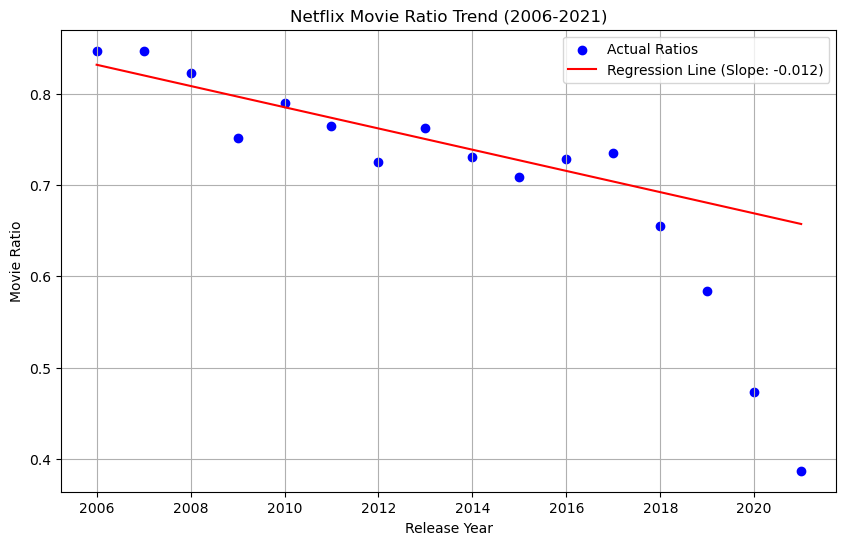


Hypothesis Test Results:
2015-2017 Mean Ratio: 0.724
2018-2021 Mean Ratio: 0.525
p-value: 0.0369


In [68]:
# Filter type_trends for years after 2005 (using release_year index)
filtered_trends = type_trends[type_trends.index.year > 2005]

# Prepare regression data
X = filtered_trends.index.year.values.reshape(-1, 1)  # Release years
y = filtered_trends['Movie_ratio'].values            # Target variable

# Split data preserving temporal order (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get regression parameters
slope = model.coef_[0]
intercept = model.intercept_
print(f"Yearly decrease in movie ratio: {slope:.4f}")
print(f"Base ratio at year 0: {intercept:.4f}")

y_pred = model.predict(X_test)


rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


# Plot results
plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Actual Ratios')
plt.plot(X, model.predict(X), color='red', 
         label=f'Regression Line (Slope: {slope:.3f})')
plt.title('Netflix Movie Ratio Trend (2006-2021)')
plt.xlabel('Release Year')
plt.ylabel('Movie Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Hypothesis testing for recent trend change
pre_shift = filtered_trends.loc['2015':'2017', 'Movie_ratio']
post_shift = filtered_trends.loc['2018':'2021', 'Movie_ratio']
t_stat, p_value = stats.ttest_ind(pre_shift, post_shift)

print(f"\nHypothesis Test Results:")
print(f"2015-2017 Mean Ratio: {pre_shift.mean():.3f}")
print(f"2018-2021 Mean Ratio: {post_shift.mean():.3f}")
print(f"p-value: {p_value:.4f}")


                               SARIMAX Results                                
Dep. Variable:            Movie_ratio   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  24.009
Date:                Thu, 24 Apr 2025   AIC                            -42.018
Time:                        20:05:00   BIC                            -39.894
Sample:                    01-01-2006   HQIC                           -42.041
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.076     13.105      0.000       0.849       1.148
ma.L1         -0.9645      0.794     -1.215      0.224      -2.521       0.592
sigma2         0.0022      0.002      1.368      0.1

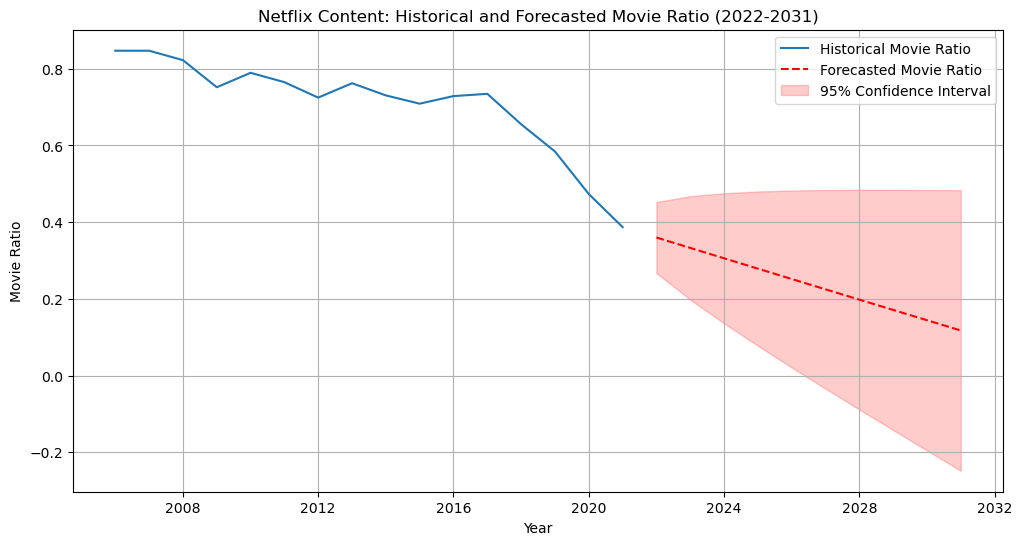


Forecasted Movie Ratios (2022-2031):
2022: 0.360 [0.267 - 0.452]
2023: 0.333 [0.198 - 0.468]
2024: 0.306 [0.136 - 0.475]
2025: 0.279 [0.078 - 0.480]
2026: 0.252 [0.021 - 0.483]
2027: 0.225 [-0.034 - 0.484]
2028: 0.198 [-0.089 - 0.484]
2029: 0.171 [-0.142 - 0.484]
2030: 0.144 [-0.195 - 0.484]
2031: 0.118 [-0.248 - 0.483]


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# Assuming type_trends is already available with the Movie_ratio column
# Filter data to focus on more recent trends (after 2005)
filtered_trends = type_trends[type_trends.index.year > 2005]

# Convert index to datetime if not already
filtered_trends.index = pd.to_datetime(filtered_trends.index)

# Extract time series for forecasting
y = filtered_trends['Movie_ratio']

# Fit the ARIMA model (p=1, d=1, q=1)
model = ARIMA(y, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast next 10 years
forecast_steps = 10
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create date range for future years
last_year = filtered_trends.index[-1].year
future_years = pd.date_range(start=f'{last_year+1}-01-01', periods=forecast_steps, freq='YS')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'forecast': forecast_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1]
}, index=future_years)

# Plot historical data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(filtered_trends.index, filtered_trends['Movie_ratio'], label='Historical Movie Ratio')
plt.plot(forecast_df.index, forecast_df['forecast'], 'r--', label='Forecasted Movie Ratio')
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], 
                 forecast_df['upper_ci'], 
                 color='r', alpha=0.2, label='95% Confidence Interval')
plt.title('Netflix Content: Historical and Forecasted Movie Ratio (2022-2031)')
plt.xlabel('Year')
plt.ylabel('Movie Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast values
print("\nForecasted Movie Ratios (2022-2031):")
for year, value, lower, upper in zip(forecast_df.index.year, 
                                   forecast_df['forecast'], 
                                   forecast_df['lower_ci'], 
                                   forecast_df['upper_ci']):
    print(f"{year}: {value:.3f} [{lower:.3f} - {upper:.3f}]")


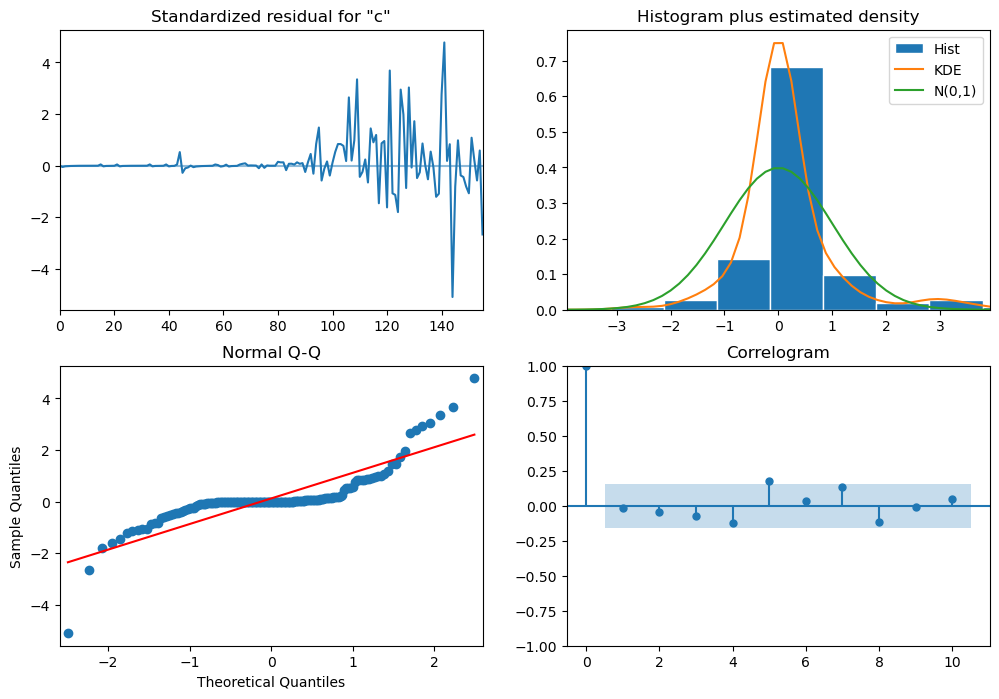

In [101]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1) model
model = ARIMA(monthly_added['counts'], order=(1,1,1))
results = model.fit()

# Generate diagnostics plot
results.plot_diagnostics(figsize=(12,8))
plt.show()
